# Deep Learning with Oxford Flowers & Tensorflow:

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

## Import Resources

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [8]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [9]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')
print('\t\u2022 TensorFlow Dataset version:', tfds.__version__)

Using:
	• TensorFlow version: 2.0.0
	• tf.keras version: 2.2.4-tf
	• GPU device not found. Running on CPU
	• TensorFlow Dataset version: 1.2.0


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [10]:
# split data into train, validation and test sets
train_split = 60
test_valid_split = 20

splits = tfds.Split.ALL.subsplit([train_split, test_valid_split, test_valid_split]) 

In [11]:
splits

(NamedSplitAll()(tfds.percent[0:60]),
 NamedSplitAll()(tfds.percent[60:80]),
 NamedSplitAll()(tfds.percent[80:100]))

In [12]:
dataset, dataset_info = tfds.load('oxford_flowers102', split=splits, as_supervised=True, with_info=True)

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/0.0.1. Subsequent calls will reuse this data.


In [13]:
train_set, valid_set, test_set = dataset

In [14]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=0.0.1,
    description='
The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1030 images each).
The test set consist of the remaining 6129 images (minimum 20 per class).
',
    urls=['https://www.robots.ox.ac.uk/~vgg/data/flowers/102/'],
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=81

## Explore the Dataset

In [15]:
print('dataset has {:,} elements and is type {}'.format(len(dataset), type(dataset)))

dataset has 3 elements and is type <class 'tuple'>


In [16]:
total_examples = dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples
print('\nThere are {:,} total examples in train and test'.format(total_examples))


There are 7,169 total examples in train and test


In [17]:
# show # of examples of train from the dataset info
num_train_examples = (total_examples * train_split) // 100
print('\nThere are {:,} images in the train set'.format(num_train_examples))


There are 4,301 images in the train set


In [18]:
# show # of examples of train from the dataset info
num_valid_examples = (total_examples * test_valid_split) // 100
print('\nThere are {:,} images in the validation set'.format(num_valid_examples))


There are 1,433 images in the validation set


In [19]:
# show # of examples in test set from the dataset info
num_test_examples = num_valid_examples
print('\nThere are {:,} images in the test set'.format(num_test_examples))


There are 1,433 images in the test set


In [20]:
# show # of classes in the dataset from the dataset info
num_classes = dataset_info.features['label'].num_classes
print('There are {:,} classes in our dataset'.format(num_classes))

There are 102 classes in our dataset


In [21]:
image_shapes =dataset_info.features['image'].shape
print('The images in our dataset have shape:', image_shapes)

The images in our dataset have shape: (None, None, 3)


In [22]:
# shape and corresponding label of 3 images in the training set.
i = 0 
for image, labels in train_set.take(3):
    i += 1
    print('The number ',  i, 'image in our train set has: ')
    print('\u2022 dtype: ', image.dtype)
    print('\u2022 shape: ', image.shape)
    print('\n\n-----------------------')
    print('The number ', i, 'label in our train set has: ')
    print('\u2022 dtype: ', labels.dtype)
    print('\n\n-----------------------')

The number  1 image in our train set has: 
• dtype:  <dtype: 'uint8'>
• shape:  (500, 752, 3)


-----------------------
The number  1 label in our train set has: 
• dtype:  <dtype: 'int64'>


-----------------------
The number  2 image in our train set has: 
• dtype:  <dtype: 'uint8'>
• shape:  (500, 666, 3)


-----------------------
The number  2 label in our train set has: 
• dtype:  <dtype: 'int64'>


-----------------------
The number  3 image in our train set has: 
• dtype:  <dtype: 'uint8'>
• shape:  (500, 667, 3)


-----------------------
The number  3 label in our train set has: 
• dtype:  <dtype: 'int64'>


-----------------------


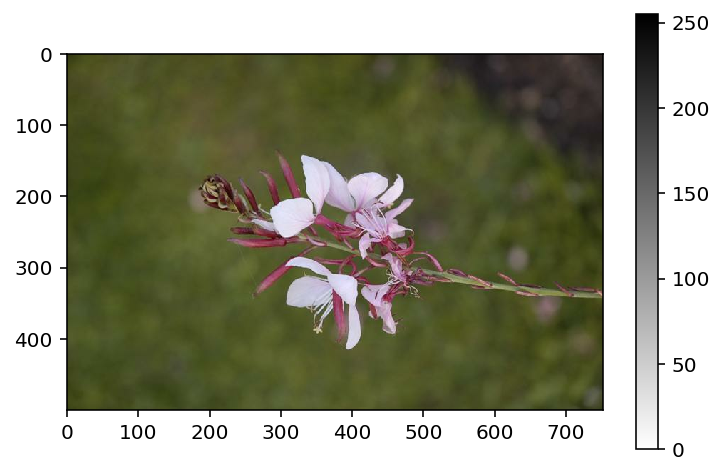

The label of this image is:  56


In [23]:
# plot 1 image from the training set
for image, label in train_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.show()
print('The label of this image is: ', label)

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [24]:
import json
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

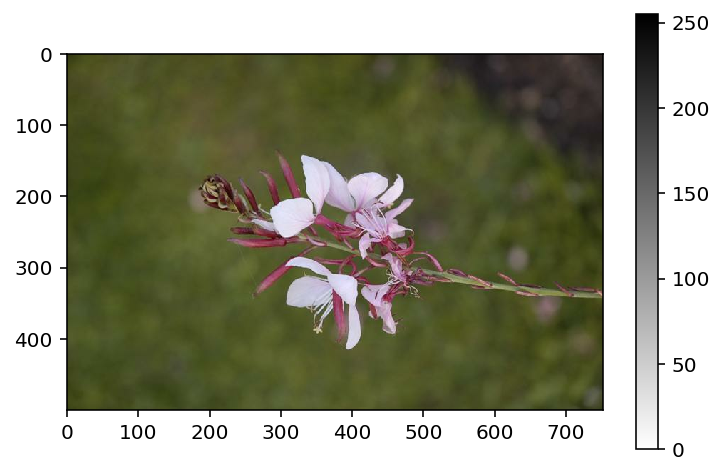

The label of this image is:  bishop of llandaff


In [25]:
# plot 1 image from the training set
name_of_flower = None

for image, label in train_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    
    for key, value in class_names.items():
        if key == str(label):
            name_of_flower = value
            break
            
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.show()
print('The label of this image is: ', name_of_flower)

## Create Pipeline

In [27]:
def image_label_preprocessing(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label

batch_size = 32
image_size = 224

train_batches = train_set.shuffle(num_train_examples//4).map(image_label_preprocessing).batch(batch_size).prefetch(1)
valid_batches = valid_set.map(image_label_preprocessing).batch(batch_size).prefetch(1)
test_batches = test_set.map(image_label_preprocessing).batch(batch_size).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

## Build & Train the Classifier Checklist:
1. Load the MobileNet pre-trained network from TensorFlow Hub.
2. Define a new, untrained feed-forward network as a classifier.
3. Train the classifier.
4. Plot the loss and accuracy values achieved during training for the training and validation set.
5. Save your trained model as a Keras model.

In [28]:
# load mobilenet
mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [29]:
# keras feature extractor
feature_extractor = hub.KerasLayer(mobilenet_url, input_shape=(224,224,3))

In [51]:
# freeze weights and biases as to not modify them during training
feature_extractor.trainable = False

In [30]:
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(102, activation = 'softmax')
])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 102)               13158     
Total params: 3,091,238
Trainable params: 833,254
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
# train model
model.compile(optimizer='adam', 
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [33]:
# set EPOCHs
EPOCHS = 10

In [34]:
# model fit
history = model.fit(train_batches, 
                    epochs=EPOCHS,
                    validation_data = valid_batches,
                    callbacks=[early_stopping]
)

Epoch 1/10
155/155 [==============================] - 618s 4s/step - loss: 2.4875 - accuracy: 0.4306 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
155/155 [==============================] - 607s 4s/step - loss: 0.7954 - accuracy: 0.7903 - val_loss: 0.7634 - val_accuracy: 0.7815
Epoch 3/10
155/155 [==============================] - 607s 4s/step - loss: 0.3979 - accuracy: 0.8943 - val_loss: 0.6157 - val_accuracy: 0.8235
Epoch 4/10
155/155 [==============================] - 607s 4s/step - loss: 0.2256 - accuracy: 0.9372 - val_loss: 0.5770 - val_accuracy: 0.8426
Epoch 5/10
155/155 [==============================] - 607s 4s/step - loss: 0.1342 - accuracy: 0.9656 - val_loss: 0.5779 - val_accuracy: 0.8531
Epoch 6/10
155/155 [==============================] - 607s 4s/step - loss: 0.0707 - accuracy: 0.9818 - val_loss: 0.5405 - val_accuracy: 0.8451
Epoch 7/10
155/155 [==============================] - 607s 4s/step - loss: 0.0467 - accuracy: 0.9881 - val_loss: 0.6318 - val_accuracy

In [39]:
# loss and accuracy values achieved on training set
train_loss, train_accuracy = model.evaluate(train_batches)
print('Loss was {:,.3f} and Accuracy was {:,.3f} on the train set'.format(train_loss, train_accuracy))

155/155 [==============================] - 463s 3s/step - loss: 0.0447 - accuracy: 0.9852
Loss was 0.045 and Accuracy was 0.985 on the train set


In [40]:
# loss and accuracy values achieved on the validation set
valid_loss, valid_accuracy = model.evaluate(valid_batches)
print('Loss was {} and Accuracy was {} on the validation set'.format(valid_loss, valid_accuracy))

51/51 [==============================] - 143s 3s/step - loss: 0.7041 - accuracy: 0.8407
Loss was 0.7041192151898262 and Accuracy was 0.8407407402992249 on the validation set


## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [42]:
# loss and accuracy values on the entire test set.
test_loss, test_accuracy = model.evaluate(test_batches)
print('Loss was {} and Accuracy was {} on the test set'.format(train_loss, train_accuracy))

51/51 [==============================] - 143s 3s/step - loss: 0.6557 - accuracy: 0.8389
Loss was 0.044744661949094267 and Accuracy was 0.9852495193481445 on the test set


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [50]:
# save your trained model as a keras model
import time
t = time.time()
saved_keras_filepath = './{}'.format(int(t))
tf.saved_model.save(model, saved_keras_filepath)

## Load the Keras Model

Load the Keras model you saved above.

In [52]:
reloaded_save_model = tf.saved_model.load(saved_keras_filepath)

# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [76]:
# create the process_image function
image_size= 224 

def process_image(image):
    image = np.squeeze(image)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image 

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

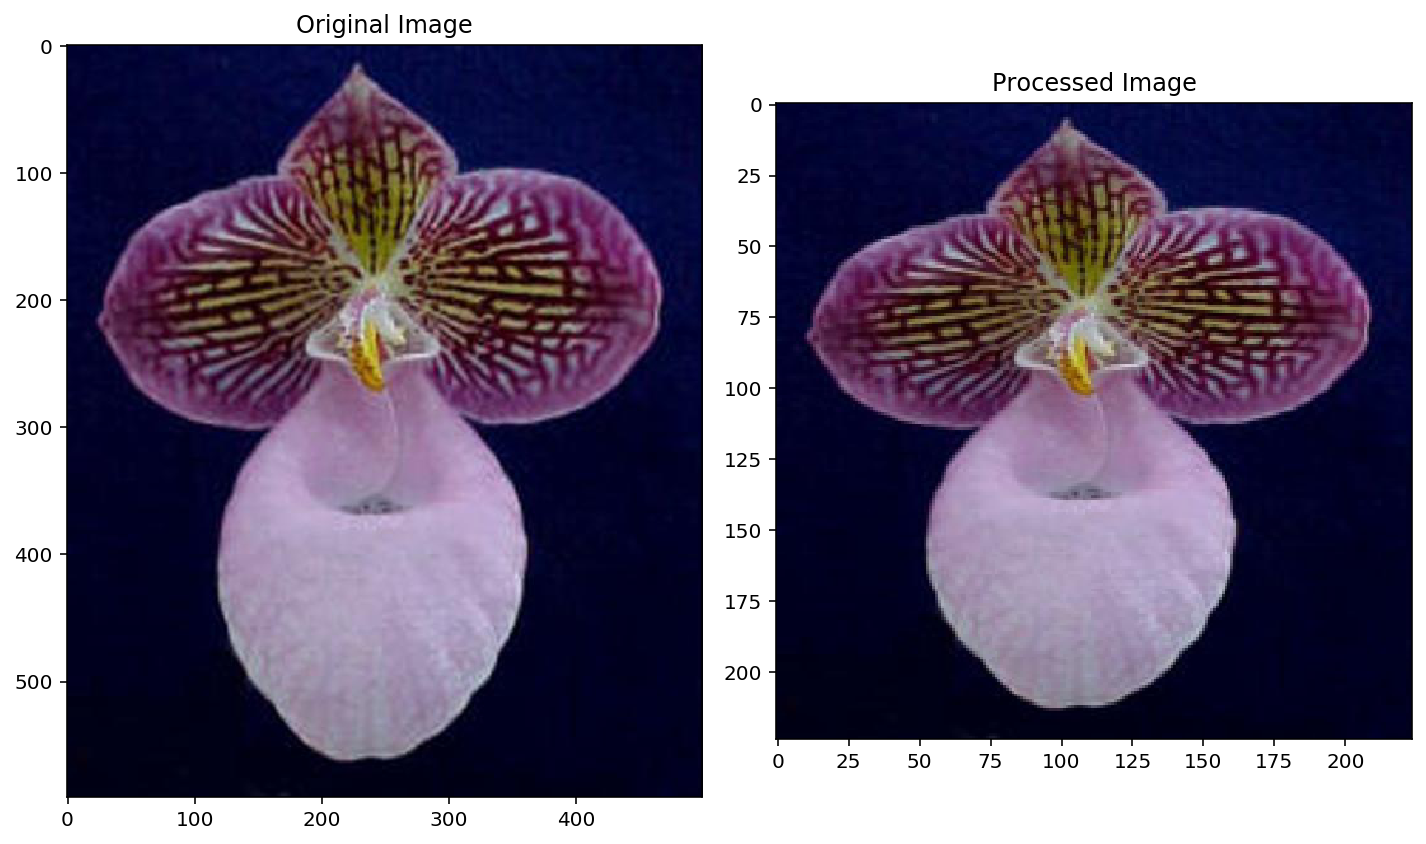

In [78]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
image = Image.open(image_path)
test_image = np.asarray(image)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [79]:
# build the predict function
def predict(image_path, model_path, top_k):
    # retrieve images from Image object and save as numpy array
    image = Image.open(image_path)
    processed_image = process_image(image)
    processed_image = np.expand_dims(processed_image, axis=0)
    tensor_image = tf.convert_to_tensor(processed_image)

    # reload saved keras model and get preds
    load_saved_model = tf.keras.models.load_model(
        model_path, custom_objects={'KerasLayer': hub.KerasLayer})

    preds = load_saved_model.predict(np.expand_dims(tensor_image, axis=0))

    # reference: https: // www.tensorflow.org/api_docs/python/tf/math/top_k
    values, indices = tf.math.top_k(preds, k=top_k, sorted=True, name=None)

    # reference: https://knowledge.udacity.com/questions/99671
    classes = [class_names[str(value+1)] for value in classes.numpy()[0]]
    probs = values

    return probs, classes

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

(0, 1.1)

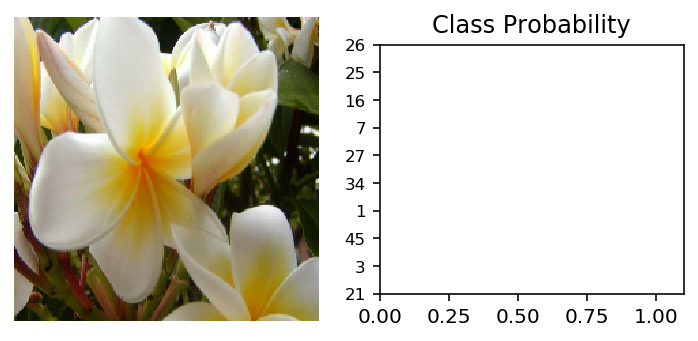

In [84]:
# plot the input image along with the top 5 classes

for image_batch, label_batch in test_batches.take(1):
    ps = model.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[0]
    first_label = label_batch.numpy()[0]
    # print(class_names, first_label)
    
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
# ax1.set_title(class_names[first_label])

# ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(class_names, size='small');
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)